# Model Performance

## Prerequisites

Install python packages


In [1]:
%%capture
%pip install pandas pydicom pydicom-seg scikit-learn seaborn requests connected-components-3d
%pip install segmentationmetrics

## Import required python packages


In [2]:
import warnings

warnings.filterwarnings("ignore")

import io
import subprocess
import zipfile
from pathlib import Path

import cc3d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
import pydicom_seg
import requests
import scipy.stats as stats
import seaborn as sns
import segmentationmetrics as sm
import SimpleITK as sitk
from google.cloud import bigquery
from scipy.ndimage import label
from segmentationmetrics.surface_distance import compute_surface_dice_at_tolerance
from tqdm.auto import tqdm

sns.set_theme(style="whitegrid")
%matplotlib inline

In [3]:
plt_colors = {
    "ne2": "#5eceb0",
    "rad1": "#9e70e1",
    "tp": "k",
    "fp": "b",
    "fn": "r",
}

revewer_cmap = sns.color_palette([plt_colors["ne2"], plt_colors["rad1"]])
vol_cmap = sns.color_palette([plt_colors["fp"], plt_colors["fn"]])

## Download the segmentation results from zenodo


In [4]:
qa_dir = Path("qa-results")

In [5]:
def download_inference(
    extract_dir="qa-results", record="13244892", filename="liver2-ct.zip"
):
    url = f"https://zenodo.org/record/{record}/files/{filename}"
    # download the zip file and extract it
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(extract_dir)


if not qa_dir.exists() or not (qa_dir / "ai-segmentations-dcm").exists():
    download_inference(qa_dir)

In [6]:
def load_dcm_seg(seg_path: Path, label=1):
    dcm = pydicom.dcmread(str(seg_path))
    reader = pydicom_seg.SegmentReader()
    result = reader.read(dcm)
    if label in result.available_segments:
        image = result.segment_image(label)
    else:
        # create an empty image
        tmp_img = result.segment_image(list(result.available_segments)[0])
        tmp_arr = sitk.GetArrayFromImage(tmp_img)
        image = sitk.GetImageFromArray(np.zeros_like(tmp_arr))
        image.CopyInformation(tmp_img)
    image = sitk.Cast(image, sitk.sitkUInt8)
    return image


def load_nii_seg(seg_path: Path, label=1):
    img = sitk.ReadImage(str(seg_path))
    if label == 1:
        img = sitk.Cast(img >= label, sitk.sitkUInt8)
    else:
        img = sitk.Cast(img == label, sitk.sitkUInt8)
    return img


def load_seg(seg_path: Path, label=1):
    if seg_path.suffix == ".dcm":
        return load_dcm_seg(seg_path, label)
    else:
        return load_nii_seg(seg_path, label)


def resize_label(img: sitk.Image, ref_img: sitk.Image, interp=sitk.sitkNearestNeighbor):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(ref_img)
    resampler.SetInterpolator(interp)
    resampler.SetDefaultPixelValue(0)
    resampled_img = resampler.Execute(img)
    return resampled_img


def tumor_report(image):
    """
    Parameters:
    - image (numpy array): The input binary image (3D array).

    Returns:
    - num_features (int): The count of unique blobs (connected components) in the image.
    """
    # Label connected components
    labeled_image, num_features = label(image)

    return num_features


def calc_metrics_for_label(
    ai_seg_file,
    qa_seg_file,
    fname,
    label_value=1,
    version="aimiv2",
    label_suffix="",
    nsd_tol=7,
):
    if isinstance(ai_seg_file, sitk.Image):
        ai_img = ai_seg_file
    else:
        ai_img = load_seg(ai_seg_file, label_value)
    if isinstance(qa_seg_file, sitk.Image):
        qa_img = qa_seg_file
    else:
        qa_img = load_seg(qa_seg_file, label_value)
    qa_img = resize_label(qa_img, ai_img)  # match the size of the ai_img
    ai_arr = sitk.GetArrayFromImage(ai_img)
    qa_arr = sitk.GetArrayFromImage(qa_img)
    spacing = ai_img.GetSpacing()[::-1]  # numpy is reversed dimensions from sitk

    qa_img = resize_label(qa_img, ai_img)  # match the size of the ai_img
    m = sm.SegmentationMetrics(ai_arr, qa_arr, spacing)
    if label_value == 1:
        tol = 7
        num_of_tumors = 0
    else:
        tol = 2
        num_of_tumors = tumor_report(ai_arr)

    metrics = {
        "dice": m.dice,
        "hausdorff_distance_95": m.hausdorff_distance,
        "mean_surface_distance": m.mean_surface_distance,
        "normalized_surface_distance": compute_surface_dice_at_tolerance(
            m._surface_dist, nsd_tol
        ),
        "SeriesUID": fname,  # from medical segmentation decathlon
        "label": label_value,
        "Lesion Count": num_of_tumors,
        "version": version,
        "normalized_surface_distance_tolerance": nsd_tol,
    }

    if label_suffix:
        metrics = {f"{k}_{label_suffix}": v for k, v in metrics.items()}
    return metrics


def con_comp(seg_array):
    # input: a binary segmentation array output: an array with seperated (indexed) connected components of the segmentation array
    connectivity = 18
    conn_comp = cc3d.connected_components(seg_array, connectivity=connectivity)
    return conn_comp


def get_discovery_rates(
    img_file_pred: str, img_file_gt: str, label_value: int = 1, prefix=""
):
    img_pred = load_seg(img_file_pred, label_value)
    img_gt = load_seg(img_file_gt, label_value)
    img_gt = resize_label(img_gt, img_pred)  # match the size of the qa_img
    gt_arr = sitk.GetArrayFromImage(img_gt)
    pred_arr = sitk.GetArrayFromImage(img_pred)
    voxel_vol = np.prod(img_pred.GetSpacing()) / 1000

    assert pred_arr.shape == gt_arr.shape, "Shape mismatch"
    # check that pred_array is binary
    assert set(np.unique(pred_arr)) in ({0}, {0, 1}), "pred_array is not binary"
    # check that gt_array is binary
    assert set(np.unique(gt_arr)) in ({0}, {0, 1}), "gt_array is not binary"

    pred_offset = pred_arr.copy()
    pred_offset[pred_offset == 1] = 2  # reset pred_array to 0,2

    combined = pred_offset + gt_arr
    tp = (combined == 3).sum() * voxel_vol
    fp = (combined == 2).sum() * voxel_vol
    fn = (combined == 1).sum() * voxel_vol

    tp_s = []
    false_pos_vols_ml = []
    false_neg_vols_ml = []

    pred_cc = con_comp(pred_arr)
    for idx in range(1, pred_cc.max() + 1):
        comp_mask = np.isin(pred_cc, idx)
        vals, cnts = np.unique(combined[comp_mask], return_counts=True)
        dect_arr = {v: c for v, c in zip(vals.tolist(), cnts.tolist())}

        if 0 in dect_arr:
            raise ValueError("should be no 0 values in the label")
        if 1 in dect_arr:
            raise ValueError("should be no 1 values in the label")
        if 3 in dect_arr:
            tp_s.append(
                (dect_arr[3], dect_arr.get(2, 0))
            )  # (true positive, false positive)
            pass  # true positive, overlaps with gt
        elif 2 in dect_arr and 1 in dect_arr:
            raise ValueError("should not be 2 and 1 values in the label")
        elif 2 in dect_arr:
            false_pos_vols_ml.append(
                dect_arr[2] * voxel_vol
            )  # false positive, does not overlap with gt
        # elif 1 in dect_arr:
        #     false_neg_vols_ml.append(
        #         dect_arr[1] * voxel_vol
        #     )  # false negative, does not overlap with pred

    gt_cc = con_comp(gt_arr)
    for idx in range(1, gt_cc.max() + 1):
        comp_mask = np.isin(gt_cc, idx)
        vals, cnts = np.unique(combined[comp_mask], return_counts=True)
        dect_arr = {v: c for v, c in zip(vals.tolist(), cnts.tolist())}

        if 0 in dect_arr:
            raise ValueError("should be no 0 values in the label")
        if 2 in dect_arr:
            raise ValueError("should be no 2 values in the label")
        elif 1 in dect_arr:
            false_neg_vols_ml.append(
                dect_arr[1] * voxel_vol
            )  # false negative, does not overlap with pred
        if 3 in dect_arr:
            continue  # true positive, overlaps with pred
        elif 2 in dect_arr and 1 in dect_arr:
            raise ValueError("should not be 2 and 1 values in the label")

    stats = {
        # "true_vol_overlap_ml": true_vol_overlap_ml,
        "false_pos_vols_ml": false_pos_vols_ml,
        "false_neg_vols_ml": false_neg_vols_ml,
        # "true_vol_overlap_ml_total": sum(true_vol_overlap_ml),
        "true_pos_pix_vol_ml_total": tp,
        "false_pos_pix_vol_ml_total": fp,
        "false_neg_pix_vol_ml_total": fn,
        "false_pos_roi_vol_ml_total": sum(false_pos_vols_ml),
        "false_neg_roi_vol_ml_total": sum(false_neg_vols_ml),
        "true_pos_roi_cnt": len(tp_s),
        "false_pos_roi_cnt": len(false_pos_vols_ml),
        "false_neg_roi_cnt": len(false_neg_vols_ml),
    }
    stats["pos_roi_cnt"] = stats["true_pos_roi_cnt"] + stats["false_neg_roi_cnt"]

    if prefix:
        stats = {f"{prefix}-{k}": v for k, v in stats.items()}

    return stats

## Calculating metrics


In [7]:
# Load the CSV file
df = pd.read_csv(Path("qa-results/qa-results.csv"))
qa_df = df[df.Validation]

# Paths for aimiv1, aimiv2, and qa
ai_path = Path("qa-results/ai-segmentations-dcm")
qa_path = Path("qa-results/qa-segmentations-dcm")

In [8]:
# labels and tolerances
label_names = {1: "Liver", 2: "Tumor"}
nsd_tolerances = {1: 7, 2: 7}  # per label tolerances in mm

In [9]:
# verify that the labels in the dcm file match the expected labels
ds = pydicom.dcmread(ai_path / df.AISegmentation.iloc[0])
result = pydicom_seg.SegmentReader().read(ds)
label_names_from_dcm = {
    k: v["SegmentDescription"].value for k, v in result.segment_infos.items()
}
assert (
    label_names_from_dcm == label_names
), "labels in the dcm file do not match expected labels"

In [10]:
# Initialize lists for metrics
metrics = []

# Iterate over all QA cases
for _, row in tqdm(qa_df.iterrows(), total=len(qa_df)):
    ai_file = ai_path / row.AISegmentation
    if not pd.isna(row.CorrectedSegmentation):
        qa_file = qa_path / row.CorrectedSegmentation
    else:
        # reviewer had no corrections, use AI segmentation as QA
        qa_file = ai_file

    assert ai_file.exists(), f"AI segmentation not found for {row.AISegmentation}"
    assert qa_file.exists(), f"QA segmentation not found for {row.QASegmentation}"

    version = "aimiv1" if row.AimiProjectYear == 2023 else "aimiv2"
    for label_value, label_name in label_names.items():
        stats = calc_metrics_for_label(
            ai_file,
            qa_file,
            row.SeriesInstanceUID,
            version=version,
            label_value=label_value,
            nsd_tol=nsd_tolerances[label_value],
        )
        stats["label_name"] = label_name
        if label_value == 2:
            detection_metrics = get_discovery_rates(
                ai_file, qa_file, label_value=label_value
            )
            # ignore array values
            for x in ("true_vol_overlap_ml", "false_neg_vols_ml", "false_pos_vols_ml"):
                if x in detection_metrics:
                    detection_metrics.pop(x)
            stats.update(detection_metrics)
        stats["Collection"] = row.Collection
        metrics.append(stats)

metrics_df = pd.DataFrame(metrics)

  0%|          | 0/52 [00:00<?, ?it/s]

In [11]:
metrics_df.to_csv("qa-metrics.csv", index=False)
metrics_df = pd.read_csv("qa-metrics.csv")

metrics_df = metrics_df.replace([np.inf, -np.inf], np.nan)
# drop na sample for volume/surface metrics
metrics_df = metrics_df.dropna(
    subset=[
        "dice",
        "hausdorff_distance_95",
        "mean_surface_distance",
        "normalized_surface_distance",
    ]
)

In [12]:
aggregated_df = (
    metrics_df.groupby(["label_name", "version"])
    .agg(
        {
            "dice": ["mean", "std"],
            "hausdorff_distance_95": ["mean", "std"],
            "mean_surface_distance": ["mean", "std"],
            "normalized_surface_distance": ["mean", "std"],
            "normalized_surface_distance_tolerance": "first",
            "pos_roi_cnt": ["sum"],
            "true_pos_roi_cnt": ["sum"],
            "false_pos_roi_cnt": ["sum"],
            "false_neg_roi_cnt": ["sum"],
            "Lesion Count": ["mean", "std"],
        }
    )
    .round(2)
)
aggregated_df

dice       hausdorff_distance_95         \
                    mean   std                  mean    std   
label_name version                                            
Liver      aimiv2   0.99  0.03                  3.36   7.61   
Tumor      aimiv2   0.80  0.35                 19.73  38.35   

                   mean_surface_distance       normalized_surface_distance  \
                                    mean   std                        mean   
label_name version                                                           
Liver      aimiv2                   0.37  0.88                        0.98   
Tumor      aimiv2                   4.38  8.70                        0.83   

                         normalized_surface_distance_tolerance pos_roi_cnt  \
                     std                                 first         sum   
label_name version                                                           
Liver      aimiv2   0.05                                     7         0.0   
Tumor      aimiv2   0.30                                     7       300.0   

                   true_pos_roi_cnt false_pos_roi_cnt false_neg_roi_cnt  \
                                sum               sum               sum   
label_name version                                                        
Liver      aimiv2               0.0               0.0               0.0   
Tumor      aimiv2             264.0              87.0              36.0   

                   Lesion Count         
                           mean    std  
label_name version                      
Liver      aimiv2          0.00   0.00  
Tumor      aimiv2          7.04  10.27

In [13]:
aggregated_df = (
    metrics_df.groupby(
        [
            "label_name",
            "Collection",
        ]
    )
    .agg(
        {
            "dice": ["mean", "std"],
            "hausdorff_distance_95": ["mean", "std"],
            "mean_surface_distance": ["mean", "std"],
            "normalized_surface_distance": ["mean", "std"],
            "normalized_surface_distance_tolerance": "first",
            "pos_roi_cnt": ["sum"],
            "true_pos_roi_cnt": ["sum"],
            "false_pos_roi_cnt": ["sum"],
            "false_neg_roi_cnt": ["sum"],
        }
    )
    .round(2)
)
aggregated_df

dice       hausdorff_distance_95  \
                                        mean   std                  mean   
label_name Collection                                                      
Liver      colorectal_liver_metastases  1.00  0.01                  1.54   
           hcc_tace_seg                 0.98  0.04                  5.33   
Tumor      colorectal_liver_metastases  0.97  0.14                 10.25   
           hcc_tace_seg                 0.62  0.41                 29.97   

                                              mean_surface_distance        \
                                          std                  mean   std   
label_name Collection                                                       
Liver      colorectal_liver_metastases   7.27                  0.13  0.54   
           hcc_tace_seg                  7.62                  0.62  1.10   
Tumor      colorectal_liver_metastases  36.70                  1.86  6.70   
           hcc_tace_seg                 38.16                  7.11  9.87   

                                       normalized_surface_distance        \
                                                              mean   std   
label_name Collection                                                      
Liver      colorectal_liver_metastases                        0.99  0.02   
           hcc_tace_seg                                       0.97  0.06   
Tumor      colorectal_liver_metastases                        0.97  0.12   
           hcc_tace_seg                                       0.67  0.36   

                                       normalized_surface_distance_tolerance  \
                                                                       first   
label_name Collection                                                          
Liver      colorectal_liver_metastases                                     7   
           hcc_tace_seg                                                    7   
Tumor      colorectal_liver_metastases                                     7   
           hcc_tace_seg                                                    7   

                                       pos_roi_cnt true_pos_roi_cnt  \
                                               sum              sum   
label_name Collection                                                 
Liver      colorectal_liver_metastases         0.0              0.0   
           hcc_tace_seg                        0.0              0.0   
Tumor      colorectal_liver_metastases       110.0            108.0   
           hcc_tace_seg                      190.0            156.0   

                                       false_pos_roi_cnt false_neg_roi_cnt  
                                                     sum               sum  
label_name Collection                                                       
Liver      colorectal_liver_metastases               0.0               0.0  
           hcc_tace_seg                              0.0               0.0  
Tumor      colorectal_liver_metastases              10.0               2.0  
           hcc_tace_seg                             77.0              34.0

<Axes: xlabel='label_name', ylabel='value'>

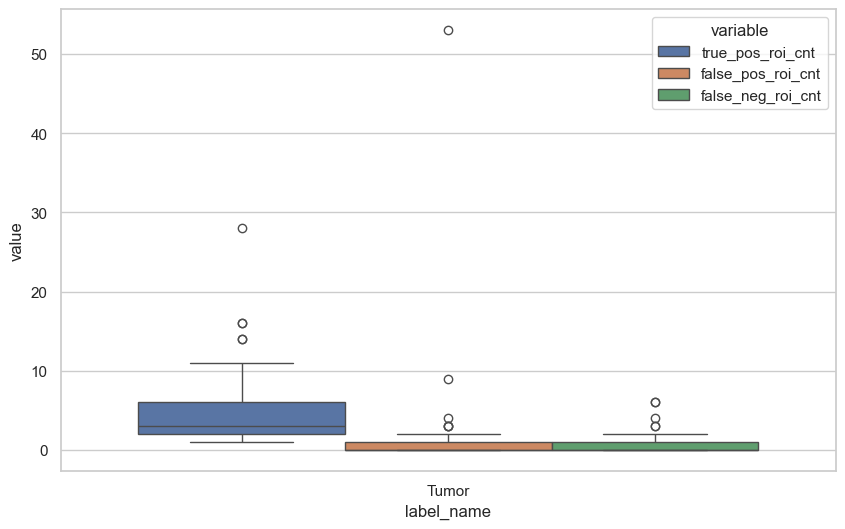

In [14]:
# plot seaborn box plot of true_pos_roi_cnt, false_pos_roi_cnt, false_neg_roi_cnt; only for Nodule
data = pd.melt(
    metrics_df[metrics_df.label_name == "Tumor"],
    id_vars=["label_name"],
    value_vars=["true_pos_roi_cnt", "false_pos_roi_cnt", "false_neg_roi_cnt"],
)
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.boxplot(
    x="label_name",
    y="value",
    hue="variable",
    data=data,
    # palette=vol_cmap,
    ax=ax,
)

In [15]:
data.groupby("variable").agg({"value": ["mean", "std"]})

value          
                       mean       std
variable                             
false_neg_roi_cnt  0.692308  1.379663
false_pos_roi_cnt  1.673077  7.419426
true_pos_roi_cnt   5.076923  5.071435

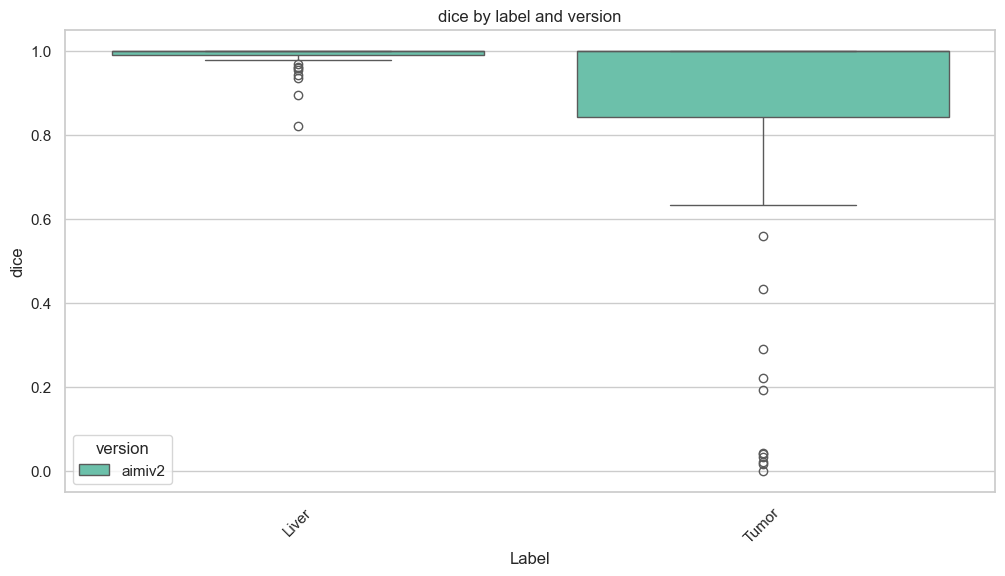

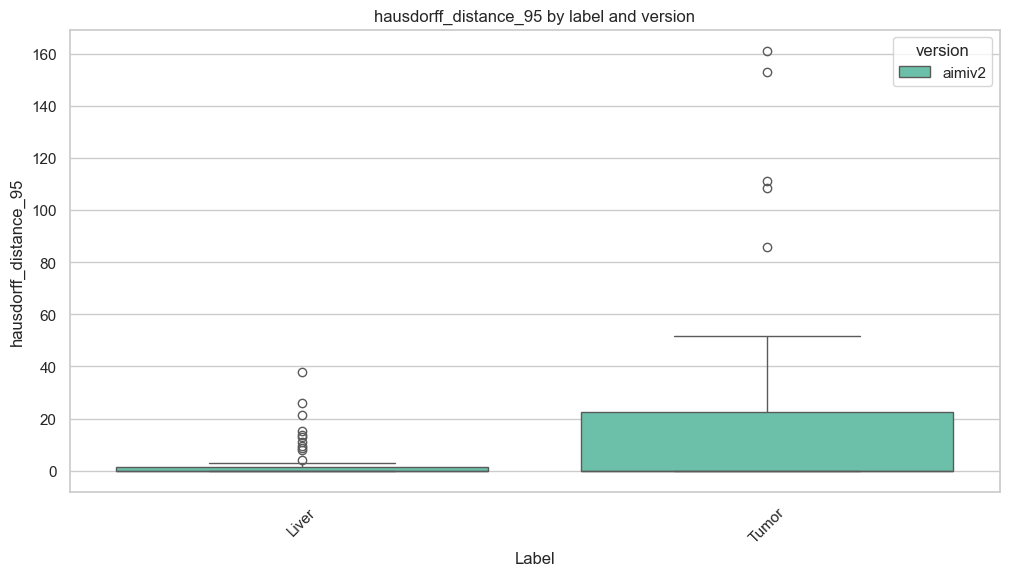

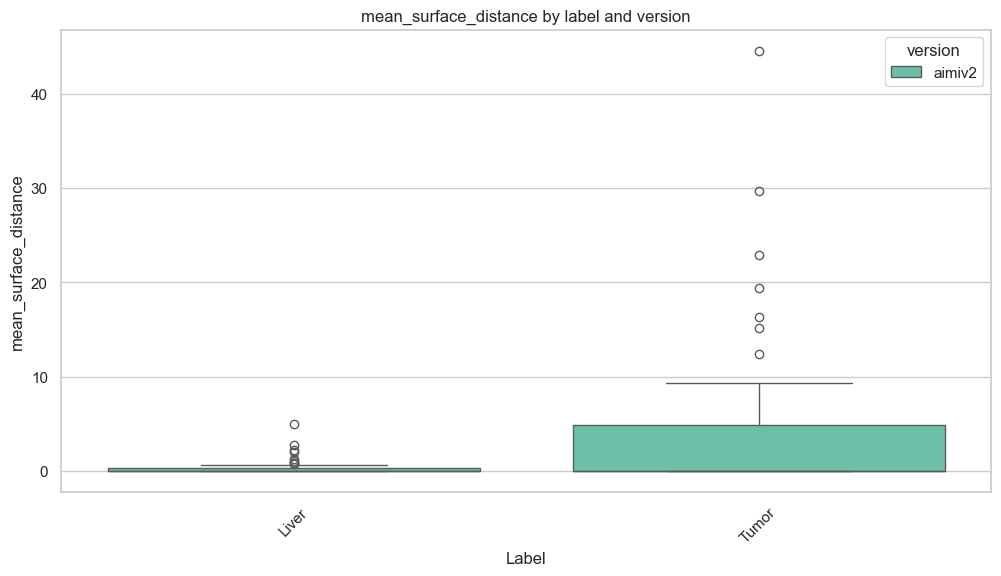

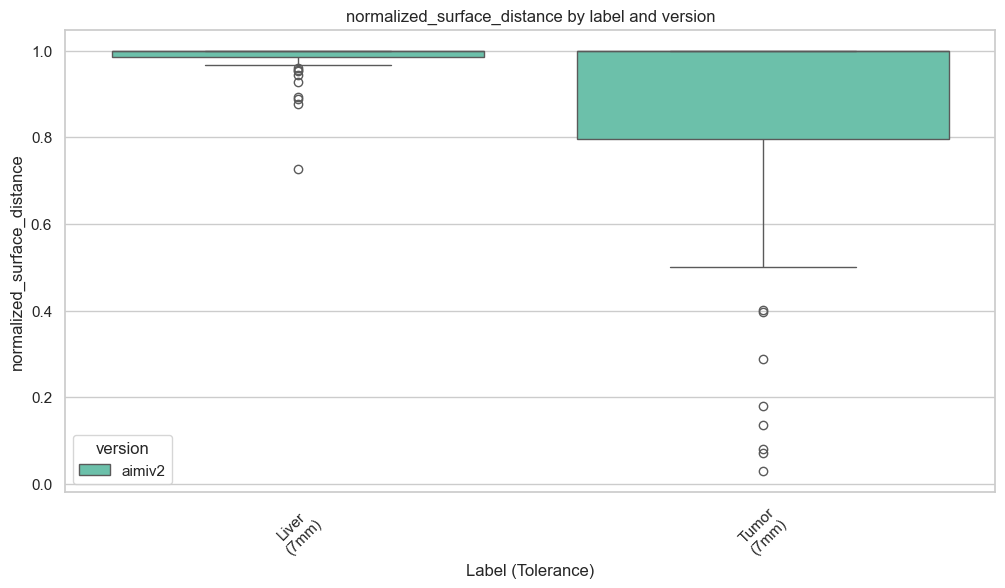

In [16]:
# create seaborn categorical boxplot for each metric, by label and version
for metric in [
    "dice",
    "hausdorff_distance_95",
    "mean_surface_distance",
    "normalized_surface_distance",
]:
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(
        x="label_name",
        y=metric,
        hue="version",
        data=metrics_df,
        palette=revewer_cmap,
        ax=ax,
    )
    if metric == "normalized_surface_distance":
        # set x axis labels to be 'label name (tolerance)'
        labels = [
            f"{label_name}\n({nsd_tolerances[label_value]}mm)"
            for label_value, label_name in label_names.items()
        ]
        ax.set_xticklabels(labels)
        ax.set_xlabel("Label (Tolerance)")
    else:
        ax.set_xlabel("Label")

    ax.set_title(f"{metric} by label and version")
    ax.set_ylabel(metric)
    plt.xticks(rotation=45)
    plt.show()

# Compare against existing segmentations

The Colorectal-Liver-Metastases dataset has semi-automated segmentaitons for the liver, tumors, and vessels. We can compare the performance of our model against these segmentations.

### Download the existing dicom segmentations from the IDC


In [17]:
# generate s5 download script
s5_download_script = Path("Colorectal-Liver-Metastases.s5cmd")

if not s5_download_script.exists():
    with open("gcp_project.txt", "r") as file:
        project_id = file.read().replace("\n", "")

    # python API is the most flexible way to query IDC BigQuery metadata tables
    bq_client = bigquery.Client(project_id)

    selection_query = f"""
  SELECT
    # Organize the files in-place right after downloading
    ANY_VALUE(CONCAT("cp s3",REGEXP_SUBSTR(gcs_url, "(://.*)/"),"/* ",collection_id,"/",PatientID,"/",StudyInstanceUID,"/",SeriesInstanceUID)) AS s5cmd_command
  FROM
    `bigquery-public-data.idc_current.dicom_all`
  WHERE
    collection_id="colorectal_liver_metastases" AND Modality="SEG" and analysis_result_id is NULL
  GROUP BY
    SeriesInstanceUID
  """

    selection_result = bq_client.query(selection_query)
    selection_df = selection_result.result().to_dataframe()
    selection_df.to_csv(s5_download_script, header=False, index=False)

In [18]:
# Download the Prostate-MRI-US-Biopsy-DICOM-Annotations dataset
s5_download_dir = Path("colorectal_liver_metastases")
if not s5_download_dir.exists():
    subprocess.run(
        f"s5cmd --no-sign-request --endpoint-url https://storage.googleapis.com run {s5_download_script}",
        shell=True,
    )

In [19]:
# segmentation file referenced series instance UID -> filepath, if that seg file has a label 'prostate'
segment_file_map = {}

files = list((s5_download_dir.rglob("*.dcm")))
for f in tqdm(files):
    dcm = pydicom.dcmread(f)
    reader = pydicom_seg.SegmentReader()
    result = reader.read(dcm)
    for segment_number in result.available_segments:
        if result.segment_infos[segment_number].SegmentLabel == "Liver":
            segment_file_map[dcm.ReferencedSeriesSequence[0].SeriesInstanceUID] = f
            break

  0%|          | 0/197 [00:00<?, ?it/s]

In [20]:
def load_colorectral_seg(seg_path: Path, label: str):
    """colorectral segs have a segment Liver, and 0+ segments for tumors (Tumor_1, Tumor_2, ...)
    extract either Liver or the combined tumor segmentations
    """
    dcm = pydicom.dcmread(str(seg_path))
    reader = pydicom_seg.SegmentReader()
    result = reader.read(dcm)

    if label == "Liver":
        for segment_number in result.available_segments:
            if result.segment_infos[segment_number].SegmentLabel == "Liver":
                image = result.segment_image(segment_number)
                break
    elif label == "Tumor":
        # create an empty image
        tmp_img = result.segment_image(list(result.available_segments)[0])
        tumor_arr = np.zeros_like(sitk.GetArrayViewFromImage(tmp_img))

        # get all tumor segments
        for segment_number in result.available_segments:
            if result.segment_infos[segment_number].SegmentLabel.startswith("Tumor"):
                tmp_arr = sitk.GetArrayFromImage(result.segment_image(segment_number))
                tumor_arr[tmp_arr > 0] = 1

        image = sitk.GetImageFromArray(tumor_arr)
        image.CopyInformation(tmp_img)
    else:
        raise ValueError(f"Unknown label {label}")

    image = sitk.Cast(image, sitk.sitkUInt8)
    return image

In [21]:
df = pd.read_csv(qa_dir / "qa-results.csv")
df = df[df["Collection"] == "colorectal_liver_metastases"]
metrics = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    seg_a_file = qa_dir / "ai-segmentations-dcm" / row["AISegmentation"]
    assert seg_a_file.exists(), f"AI segmentation {seg_a_file} does not exist"
    seg_b_file = segment_file_map.get(row["SeriesInstanceUID"])
    if seg_b_file is None:
        print(f"QA segmentation not found for {row['SeriesInstanceUID']}")
        continue

    img_a = load_dcm_seg(seg_a_file, label=1)
    img_b = load_colorectral_seg(seg_b_file, "Liver")
    metric = calc_metrics_for_label(
        img_a, img_b, row.SeriesInstanceUID, version="colorectal_liver_metastases"
    )
    metric["label_name"] = "Liver"
    metrics.append(metric)

    img_a = load_dcm_seg(seg_a_file, 2)
    img_b = load_colorectral_seg(seg_b_file, "Tumor")
    metric = calc_metrics_for_label(
        img_a, img_b, row.SeriesInstanceUID, version="colorectal_liver_metastases"
    )
    metric["label_name"] = "Tumor"
    detection_metrics = get_discovery_rates(ai_file, qa_file, label_value=label_value)
    # ignore array values
    for x in ("true_vol_overlap_ml", "false_neg_vols_ml", "false_pos_vols_ml"):
        if x in detection_metrics:
            detection_metrics.pop(x)
    metric.update(detection_metrics)

    metrics.append(metric)

clm_metrics_df = pd.DataFrame(metrics)

# Replace infinite values with NaN and drop NaN values
# metrics_df = metrics_df.replace([np.inf, -np.inf], np.nan).dropna()

  0%|          | 0/197 [00:00<?, ?it/s]

In [22]:
aggregated_df = (
    clm_metrics_df.groupby(["label_name", "version"])
    .agg(
        {
            "dice": ["mean", "std"],
            "hausdorff_distance_95": ["mean", "std"],
            "mean_surface_distance": ["mean", "std"],
            "normalized_surface_distance": ["mean", "std"],
            "normalized_surface_distance_tolerance": "first",
            "pos_roi_cnt": ["sum"],
            "true_pos_roi_cnt": ["sum"],
            "false_pos_roi_cnt": ["sum"],
            "false_neg_roi_cnt": ["sum"],
        }
    )
    .round(2)
)
aggregated_df

dice       hausdorff_distance_95  \
                                        mean   std                  mean   
label_name version                                                         
Liver      colorectal_liver_metastases  0.95  0.03                  7.71   
Tumor      colorectal_liver_metastases  0.66  0.23                 42.93   

                                              mean_surface_distance         \
                                          std                  mean    std   
label_name version                                                           
Liver      colorectal_liver_metastases   6.49                  1.19   0.60   
Tumor      colorectal_liver_metastases  46.71                  8.63  14.64   

                                       normalized_surface_distance        \
                                                              mean   std   
label_name version                                                         
Liver      colorectal_liver_metastases                        0.97  0.03   
Tumor      colorectal_liver_metastases                        0.85  0.23   

                                       normalized_surface_distance_tolerance  \
                                                                       first   
label_name version                                                             
Liver      colorectal_liver_metastases                                     7   
Tumor      colorectal_liver_metastases                                     7   

                                       pos_roi_cnt true_pos_roi_cnt  \
                                               sum              sum   
label_name version                                                    
Liver      colorectal_liver_metastases         0.0              0.0   
Tumor      colorectal_liver_metastases      1379.0           1379.0   

                                       false_pos_roi_cnt false_neg_roi_cnt  
                                                     sum               sum  
label_name version                                                          
Liver      colorectal_liver_metastases               0.0               0.0  
Tumor      colorectal_liver_metastases               0.0               0.0

<Axes: xlabel='label_name', ylabel='value'>

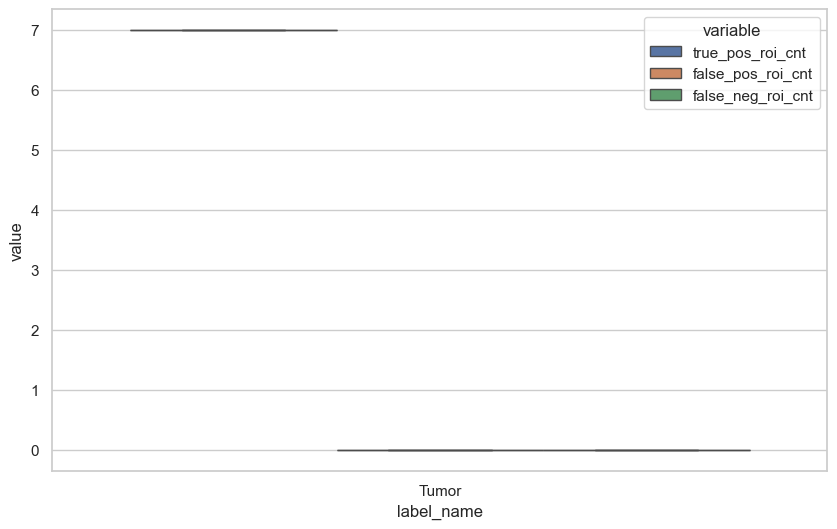

In [23]:
# plot seaborn box plot of true_pos_roi_cnt, false_pos_roi_cnt, false_neg_roi_cnt; only for Nodule
clm_data = pd.melt(
    clm_metrics_df[clm_metrics_df.label_name == "Tumor"],
    id_vars=["label_name"],
    value_vars=["true_pos_roi_cnt", "false_pos_roi_cnt", "false_neg_roi_cnt"],
)
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.boxplot(
    x="label_name",
    y="value",
    hue="variable",
    data=clm_data,
    # palette=vol_cmap,
    ax=ax,
)

In [24]:
clm_data.groupby("variable").agg({"value": ["mean", "std"]})

value     
                   mean  std
variable                    
false_neg_roi_cnt   0.0  0.0
false_pos_roi_cnt   0.0  0.0
true_pos_roi_cnt    7.0  0.0

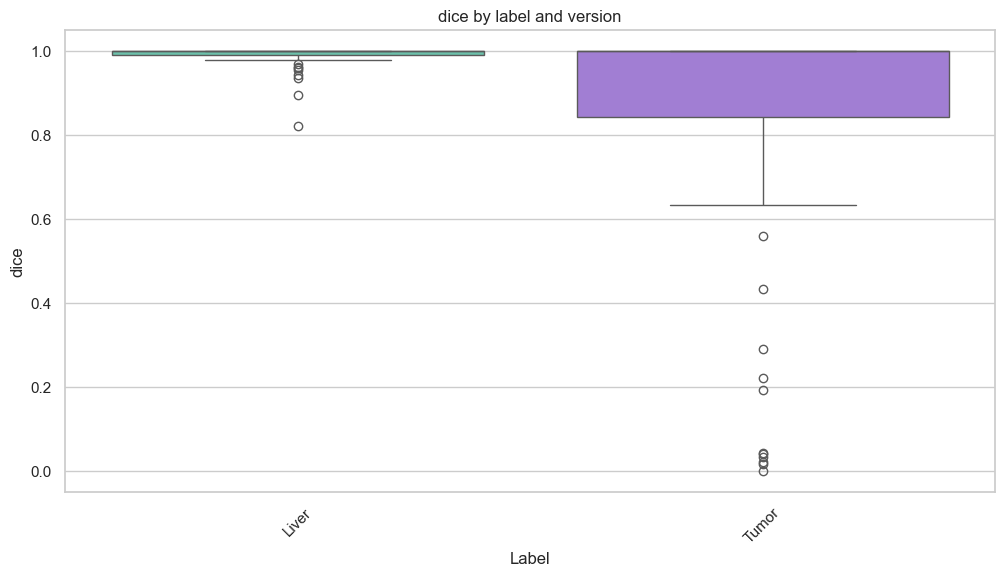

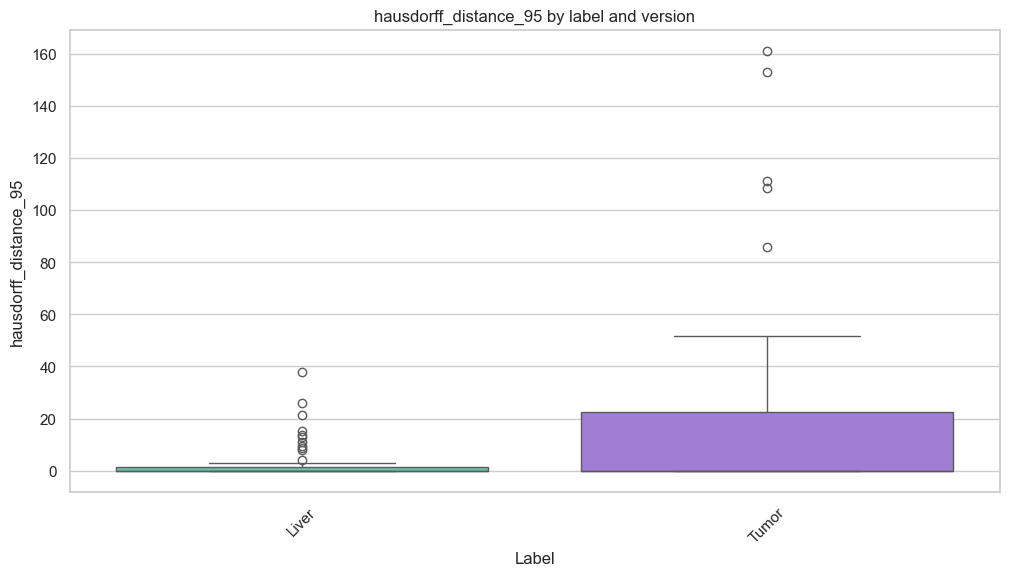

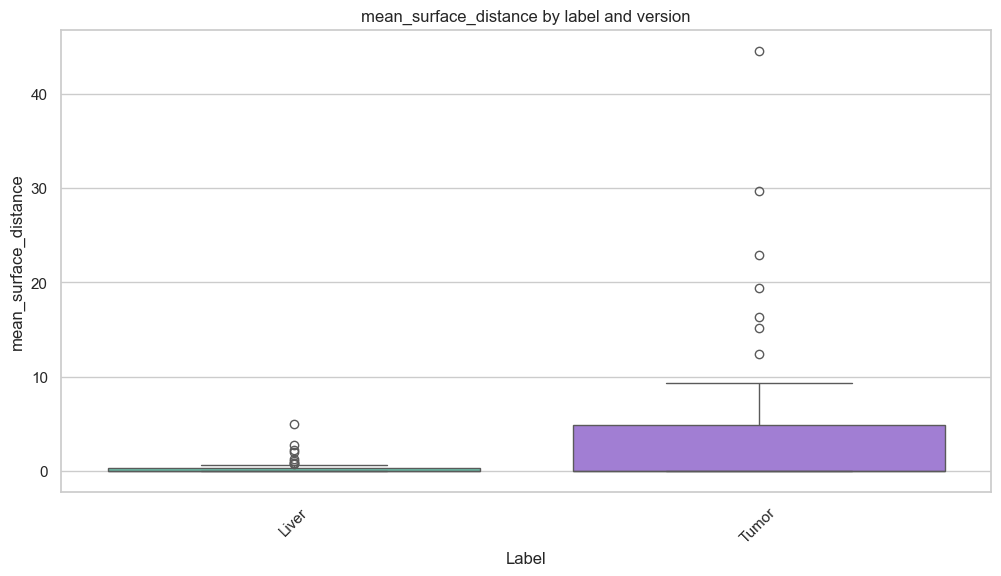

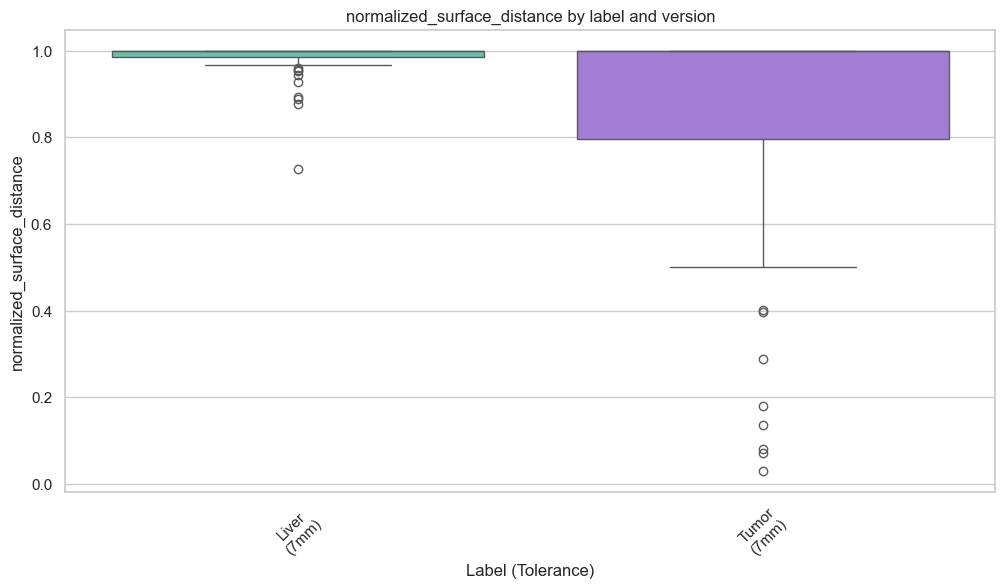

In [25]:
# create seaborn categorical boxplot for each metric, by label and version
for metric in [
    "dice",
    "hausdorff_distance_95",
    "mean_surface_distance",
    "normalized_surface_distance",
]:
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(
        x="label_name",
        y=metric,
        # hue="version",
        data=metrics_df,
        palette=revewer_cmap,
        ax=ax,
    )
    if metric == "normalized_surface_distance":
        # set x axis labels to be 'label name (tolerance)'
        labels = [
            f"{label_name}\n({nsd_tolerances[label_value]}mm)"
            for label_value, label_name in label_names.items()
        ]
        ax.set_xticklabels(labels)
        ax.set_xlabel("Label (Tolerance)")
    else:
        ax.set_xlabel("Label")

    ax.set_title(f"{metric} by label and version")
    ax.set_ylabel(metric)
    plt.xticks(rotation=45)
    plt.show()